## Adam's Part

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob 

%matplotlib inline

#read in the data from the CSV file
#did not use ID as index because it will be easier to model (train/test data) this way 
df = pd.read_csv('train.csv', index_col = None)

#given that we would like to predict the review of each listing, we remove listings that have not been rated
df = df.dropna(subset=['review_scores_rating'])

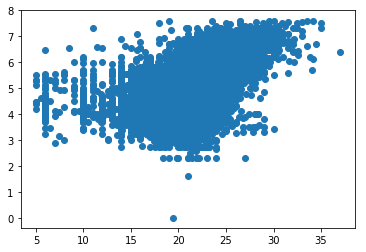

In [132]:
import math

#from the standpoint of agility, let us create a rough model, relating price of a suite to the number of bedrooms and bathrooms
#also tried it with some consideratin for the average review
#while no clear model arises from this attempt, it does appear that this model creates a lower bound
plt.scatter(df.bathrooms+df.bedrooms+0.2*df.review_scores_rating, df.log_price)

In [133]:
#the next step is to convert many of our categorical data columns into numbers
#start with bed_type, where we can use: Real Bed = 4, Pull-out Sofa or Futon = 3, Couch = 2, Airbed = 1, in order of luxury
bed_data = [['Real Bed',4],['Pull-out Sofa',3],['Futon',3],['Couch',2],['Airbed',1]]
df_bed_data = pd.DataFrame(bed_data,columns=['bed_type','bed_val'])
df = df.join(df_bed_data.set_index('bed_type'),on = 'bed_type')
df = df.drop('bed_type', axis = 1)


In [134]:
#continue with cancellation_policy, where we can use: super_strict_60 = 5, super_strict_30 = 4, strict = 3, 
# moderate = 2, flexible = 1, in order of severity
cancel_data = [['super_strict_60',5],['super_strict_30',4],['strict',3],['moderate',2],['flexible',1]]
df_cancel_type = pd.DataFrame(cancel_data,columns=['cancellation_policy','cancellation_val'])
df = df.join(df_cancel_type.set_index('cancellation_policy'),on = 'cancellation_policy')
df = df.drop('cancellation_policy', axis = 1)

In [135]:
#continue with cleaning_fee, where we can use: True = 1 and False = 0
df['cleaning_fee']= np.where(df['cleaning_fee']== True,1,0)

In [136]:
#the date of last review and the thumbnail_url will not be used in the price modeling so we drop these columns here
df = df.drop(['thumbnail_url'], axis = 1)
print(len(df.columns))

28


In [137]:
#continue with room_type, where we can use: Entire home/apt = 3, Private room = 2, and Shared room = 1
roomtype_data = [['Entire home/apt',3],['Private room',2],['Shared room',1]]
df_roomtype = pd.DataFrame(roomtype_data,columns=['room_type','roomtype_val'])
df = df.join(df_roomtype.set_index('room_type'),on = 'room_type')
df = df.drop('room_type', axis = 1)
df.head()

,id,log_price,property_type,amenities,accommodates,bathrooms,cleaning_fee,city,description,first_review,...,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,bed_val,cancellation_val,roomtype_val
0,6901257,5.010635,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,1,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,...,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,11201,1.0,1.0,4,3,3
1,6304928,5.129899,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,1,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,...,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,10019,3.0,3.0,4,3,3
2,7919400,4.976734,Apartment,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,1,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,...,The Garden Oasis,Harlem,10,92.0,10027,1.0,3.0,4,2,3
4,3808709,4.744932,Apartment,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,1,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,...,Great studio in midtown DC,Columbia Heights,4,40.0,20009,0.0,1.0,4,2,3
5,12422935,4.442651,Apartment,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,1,SF,Beautiful private room overlooking scenic view...,2017-08-27,...,Comfort Suite San Francisco,Noe Valley,3,100.0,94131,1.0,1.0,4,3,2


In [138]:
#continue with city, where we can create a separate column for each of: Boston, Chicago, DC, LA, NYC, SF

df['Boston'] = (df['city'] == "Boston").astype(int)
df['Chicago'] = (df['city'] == "Chicago").astype(int)
df['DC'] = (df['city'] == "DC").astype(int)
df['LA'] = (df['city'] == "LA").astype(int)
df['NYC'] = (df['city'] == "NYC").astype(int)
df['SF'] = (df['city'] == "SF").astype(int)
df = df.drop('city', axis = 1)
df.head()

,id,log_price,property_type,amenities,accommodates,bathrooms,cleaning_fee,description,first_review,host_has_profile_pic,...,beds,bed_val,cancellation_val,roomtype_val,Boston,Chicago,DC,LA,NYC,SF
0,6901257,5.010635,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,1,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,...,1.0,4,3,3,0,0,0,0,1,0
1,6304928,5.129899,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,1,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,...,3.0,4,3,3,0,0,0,0,1,0
2,7919400,4.976734,Apartment,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,1,The Oasis comes complete with a full backyard ...,2017-04-30,t,...,3.0,4,2,3,0,0,0,0,1,0
4,3808709,4.744932,Apartment,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,1,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,...,1.0,4,2,3,0,0,1,0,0,0
5,12422935,4.442651,Apartment,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,1,Beautiful private room overlooking scenic view...,2017-08-27,t,...,1.0,4,3,2,0,0,0,0,0,1


In [139]:
#continue with host_has_profile_pic, Host_identity_verified, and instant_bookable, where we can use: t = 1 and f = 0
df['host_has_profile_pic']= np.where(df['host_has_profile_pic']== 't',1,0)
df['host_identity_verified']= np.where(df['host_identity_verified']== 't',1,0)
df['instant_bookable']= np.where(df['instant_bookable']== 't',1,0)
df.head()

,id,log_price,property_type,amenities,accommodates,bathrooms,cleaning_fee,description,first_review,host_has_profile_pic,...,beds,bed_val,cancellation_val,roomtype_val,Boston,Chicago,DC,LA,NYC,SF
0,6901257,5.010635,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,1,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1,...,1.0,4,3,3,0,0,0,0,1,0
1,6304928,5.129899,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,1,Enjoy travelling during your stay in Manhattan...,2017-08-05,1,...,3.0,4,3,3,0,0,0,0,1,0
2,7919400,4.976734,Apartment,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,1,The Oasis comes complete with a full backyard ...,2017-04-30,1,...,3.0,4,2,3,0,0,0,0,1,0
4,3808709,4.744932,Apartment,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,1,"Cool, cozy, and comfortable studio located in ...",2015-05-12,1,...,1.0,4,2,3,0,0,1,0,0,0
5,12422935,4.442651,Apartment,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,1,Beautiful private room overlooking scenic view...,2017-08-27,1,...,1.0,4,3,2,0,0,0,0,0,1


In [140]:
#continue with host_response_rate, Host_identity_verified, and instant_bookable, where we can use: t = 1 and f = 0
#remove the '%' sign at the end of each entry
df['host_response_rate']= df['host_response_rate'].str.strip('%')
df.head()

,id,log_price,property_type,amenities,accommodates,bathrooms,cleaning_fee,description,first_review,host_has_profile_pic,...,beds,bed_val,cancellation_val,roomtype_val,Boston,Chicago,DC,LA,NYC,SF
0,6901257,5.010635,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,1,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1,...,1.0,4,3,3,0,0,0,0,1,0
1,6304928,5.129899,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,1,Enjoy travelling during your stay in Manhattan...,2017-08-05,1,...,3.0,4,3,3,0,0,0,0,1,0
2,7919400,4.976734,Apartment,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,1,The Oasis comes complete with a full backyard ...,2017-04-30,1,...,3.0,4,2,3,0,0,0,0,1,0
4,3808709,4.744932,Apartment,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,1,"Cool, cozy, and comfortable studio located in ...",2015-05-12,1,...,1.0,4,2,3,0,0,1,0,0,0
5,12422935,4.442651,Apartment,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,1,Beautiful private room overlooking scenic view...,2017-08-27,1,...,1.0,4,3,2,0,0,0,0,0,1


In [141]:
import datetime

#convert dates into 'datetime format'
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

#create a new variable to determine the frequency of listing reviews
#subtract the time between the first and last review and then divide by the number of reviews to get # of days between reviews
df['freq_review'] = df['last_review'].sub(df['first_review'], axis=0)
df['freq_review'] /= np.timedelta64(1, 'D')
df['freq_review'] /= df['number_of_reviews']
df.head()

,id,log_price,property_type,amenities,accommodates,bathrooms,cleaning_fee,description,first_review,host_has_profile_pic,...,bed_val,cancellation_val,roomtype_val,Boston,Chicago,DC,LA,NYC,SF,freq_review
0,6901257,5.010635,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,1,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1,...,4,3,3,0,0,0,0,1,0,15.000000
1,6304928,5.129899,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,1,Enjoy travelling during your stay in Manhattan...,2017-08-05,1,...,4,3,3,0,0,0,0,1,0,8.166667
2,7919400,4.976734,Apartment,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,1,The Oasis comes complete with a full backyard ...,2017-04-30,1,...,4,2,3,0,0,0,0,1,0,13.700000
4,3808709,4.744932,Apartment,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,1,"Cool, cozy, and comfortable studio located in ...",2015-05-12,1,...,4,2,3,0,0,1,0,0,0,155.250000
5,12422935,4.442651,Apartment,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,1,Beautiful private room overlooking scenic view...,2017-08-27,1,...,4,3,2,0,0,0,0,0,1,3.000000


In [142]:
#the strategy here is to convert the date the user started hosting to number of days hosting (host experience)
#use January 1, 2018 as a reference date since all data is 2017 or earlier
date_ref = pd.to_datetime('2018-01-01')

#convert 'host_since' column to date_time
df['host_since'] = pd.to_datetime(df['host_since'])

#subtract 'host_since' from reference date
df['host_since'] = date_ref - df['host_since']
df['host_since'] /= np.timedelta64(1, 'D')
df.head()

,id,log_price,property_type,amenities,accommodates,bathrooms,cleaning_fee,description,first_review,host_has_profile_pic,...,bed_val,cancellation_val,roomtype_val,Boston,Chicago,DC,LA,NYC,SF,freq_review
0,6901257,5.010635,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,1,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1,...,4,3,3,0,0,0,0,1,0,15.000000
1,6304928,5.129899,Apartment,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,1,Enjoy travelling during your stay in Manhattan...,2017-08-05,1,...,4,3,3,0,0,0,0,1,0,8.166667
2,7919400,4.976734,Apartment,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,1,The Oasis comes complete with a full backyard ...,2017-04-30,1,...,4,2,3,0,0,0,0,1,0,13.700000
4,3808709,4.744932,Apartment,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,1,"Cool, cozy, and comfortable studio located in ...",2015-05-12,1,...,4,2,3,0,0,1,0,0,0,155.250000
5,12422935,4.442651,Apartment,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,1,Beautiful private room overlooking scenic view...,2017-08-27,1,...,4,3,2,0,0,0,0,0,1,3.000000


## Sree's Parts

In [143]:
# resets index since we dropped rows and I need to use loops referencing the indices
df = df.reset_index().drop(columns = ['index'])

In [144]:
# cleaning amenities list to remove '{','}'
# standardizing to single quotes
# creating a list of all amenities
all_amenities = [df['amenities'][i].replace("{","").replace("}","").replace('"', '').split(",") for i in range(len(df['amenities']))]

In [145]:
# identifying unique amenities across all rows of the dataframe
unique_amenities = pd.unique([val for sublist in all_amenities for val in sublist]).tolist()
unique_amenities.remove('')

In [146]:
# creating combined dataframe to include each of the unique amenities as the columns
df = pd.concat([df,pd.DataFrame(columns = unique_amenities)], sort=False)
df[unique_amenities] = 0

### This function does one hot encoding for amenities for each property (row in the dataframe).

In [147]:
# function obtains list of amenities for each row
# function looks for individual amenity name in dataframe columns
# function assigns 1 to that amenity column for that row if amenity is present in list of amenities for that rowa
def apply_amenities(df_row):
    clean_list = df_row['amenities'].replace("{","").replace("}","").replace('"', '').split(',')
    for i in range(len(clean_list)):
        df_row[clean_list[i]] = 1
    return df_row

In [148]:
#apply function onto dataframe
df = df.apply(apply_amenities, axis = 1).drop(columns=[''], axis = 1)

In [149]:
df.head(5)

,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,roomtype_val,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,zipcode
0,0,0,0,0,1,0,0,0,0,0,...,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2.0,Apartment,100.0,3.0,0,1,11201
1,0,0,0,0,1,0,0,0,0,0,...,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6.0,Apartment,93.0,3.0,0,1,10019
2,0,0,0,0,1,0,0,0,0,0,...,-73.943756,The Garden Oasis,Harlem,10.0,Apartment,92.0,3.0,0,1,10027
3,0,0,0,0,1,0,0,0,0,0,...,-77.034596,Great studio in midtown DC,Columbia Heights,4.0,Apartment,40.0,3.0,0,0,20009
4,0,0,0,0,0,0,0,0,0,0,...,-122.429526,Comfort Suite San Francisco,Noe Valley,3.0,Apartment,100.0,2.0,0,0,94131


## Esha's Part

In [150]:
#Use standard library glob to read all relevant files using regular expression 
gbpath = []
gbpath = glob.glob("16*.xls")

irs = pd.concat([pd.read_excel(f,header=None) for f in gbpath])

In [151]:
irs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0.0,"$1 under $25,000",5975570.0,4192510.0,774400.0,940840.0,3507450.0,8877550.0,2969880.0,182750.0,...,3119640.0,3147718.0,20.0,9.0,70.0,110.0,843690.0,783942.0,4707030.0,9411130.0
1,0.0,"$25,000 under $50,000",4168180.0,2113080.0,1075050.0,912660.0,2571270.0,8672900.0,3453670.0,85770.0,...,3373610.0,9189547.0,20.0,5.0,60.0,23.0,782510.0,1423468.0,3309570.0,8311140.0


In [152]:
irsNoNA = irs.dropna(how='all').fillna(" ")
irsNoNA = irsNoNA.loc[irsNoNA[1] == " "]

In [153]:
# IRS files are huge with 144 columns and over 10000 rows. Remove unwanted rows
irsnewf = irsNoNA.drop([1]+[i for (k,l) in [(3,7),(8,16),(17,69),(71,75),(77,145)] for i in range(k,l)],axis=1)
irsnewf.columns = ['zipCode','No of households','Population','AGI','RealTaxNo','RealTaxA','HomeMorNo','HomeMorA']

In [154]:
#Compute:
#Average real estate taxes paid per household (AvgRealTax)
#Average Home mortgage paid per household (AvgHomeMor) 
#Average Adjusted Gross Income per household (AvgIncomePerHH)
irsnewf['AvgRealTax'] = np.divide(irsnewf['RealTaxA'],irsnewf['RealTaxNo'])
irsnewf['AvgHomeMor'] = np.divide(irsnewf['HomeMorA'],irsnewf['HomeMorNo'])
irsnewf['AvgIncomePerHH'] = np.divide(irsnewf['AGI'],irsnewf['No of households'])

C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [155]:
#Covert default float value to int for zipcode
irsnewf['zipcode'] = pd.to_numeric(irsnewf['zipCode'], downcast = 'integer')
#newf.loc[(newf["ZIPCode"] > 90000) & (newf["ZIPCode"] < 100000)].sort_values(by='AGI',ascending = False) 
##Do some visualizations

In [156]:
# #These rows (14) have invalid values for zipcode. This 
# dropInvalidRows = [8340381,5755232,18915873,19007785,17779879,10565104,19086890,16810190,19927120,17515059,10104806,9058111,13079560,6763587]
# for dr in dropInvalidRows:
#     df.drop(df[df.id == dr].index,inplace=True)

# ##Use train since its inpace
# df[df.id == 8340381]

In [158]:
#These rows (14) have invalid values for zipcode. Replace with valid records
InvalidRows = [8340381,5755232,18915873,19007785,17779879,10565104,19086890,16810190,19927120,17515059,10104806,9058111,13079560,6763587]
VRows = [20007,10003,95202,11103,11385,91606,11249,91001,90039,20001,10023,90034,60660,90036]
for iv,v in zip(InvalidRows,VRows):
    df.loc[df["id"] == iv,['zipcode']] = v
df[df.id == 5755232]

,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,roomtype_val,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,zipcode
1665,0,1,0,0,1,0,0,0,0,0,...,-73.990818,★ Large Prime Cozy E Village Apt ★,East Village,147.0,Apartment,96.0,3.0,0,0,10003


In [160]:
#Covert zip to int before merge
df['zipcode'] = pd.to_numeric(df['zipcode'],downcast='integer',errors='coerce')

In [161]:
#Left join to ensure all the rows from the original DF don't get truncated. 
dfFinal = df.merge(irsnewf,how='left',on='zipcode')
df = dfFinal

In [163]:
df.sample(10)

,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,roomtype_val,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,zipcode
3837,0,0,0,0,1,0,0,0,0,0,...,-73.816868,Cozy bedroom near all,Richmond Hill,81.0,Apartment,92.0,2.0,0,0,11419.0
38589,0,0,0,0,1,0,0,0,0,0,...,-117.956619,"Cozy 2 bedrooms 1 bath, parking",NaN,1.0,House,100.0,2.0,0,1,91745.0
2185,0,0,0,0,1,0,0,0,0,0,...,-73.931307,Wonderful Getaway in Bedstuy,Bedford-Stuyvesant,26.0,Apartment,90.0,2.0,0,0,11221.0
26093,0,0,0,0,1,0,0,0,0,0,...,-118.365178,"Beverly Grove - West Hollywood, Great Private...",Mid-Wilshire,6.0,Apartment,90.0,3.0,1,1,90048.0
46811,0,0,0,0,0,0,0,0,0,0,...,-73.912592,Sunny Bedroom in a Brownstone,Bedford-Stuyvesant,25.0,Apartment,97.0,2.0,1,0,11233.0
12945,0,0,0,0,0,0,0,0,0,0,...,-122.472743,"Modern, comfy 2bed/2bath awaits on SF's best b...",Inner Sunset,9.0,Apartment,98.0,3.0,0,0,94122.0
54360,0,0,0,0,1,0,1,1,0,1,...,-73.950562,Upper East Side Luxury One Bedroom w/ City Views,Upper East Side,1.0,Apartment,100.0,3.0,0,0,10028.0
8527,0,1,0,0,1,0,0,0,0,0,...,-118.344464,Elite life Style in WEHO,West Hollywood,5.0,Apartment,96.0,3.0,0,0,90046.0
46716,0,0,0,0,1,0,0,0,0,0,...,-73.778314,Cozy and Comfy Room,Jamaica,10.0,House,96.0,2.0,0,1,11434.0
51674,0,0,0,0,1,0,0,0,0,0,...,-73.970472,Sunny/Spacious Fort Greene Studio,Fort Greene,10.0,Apartment,90.0,3.0,0,0,11205.0
